In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
# import plotly.offline as py
# import plotly.graph_objs as go
# py.init_notebook_mode(connected=True)
%matplotlib inline

2023-03-28 21:05:43.528137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Import test data

In [2]:
data = pd.read_csv('raw_data.csv')
data

,scrape_time,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02
0,2023-03-27 10:30:36,17668615506,27905.28,12.59899,27904.92,0.01921,27905.29,1.58571,27905.30,1.02708
1,2023-03-27 10:30:41,17668615812,27905.28,13.05932,27905.15,0.00208,27905.29,3.29816,27905.30,0.00252
2,2023-03-27 10:30:45,17668616793,27909.14,10.13004,27909.03,0.09094,27909.15,5.28372,27909.94,0.09800
3,2023-03-27 10:30:50,17668617069,27909.14,9.63960,27909.03,0.09094,27909.15,5.83321,27909.16,0.00401
4,2023-03-27 10:30:54,17668617292,27909.14,0.22453,27908.60,0.00559,27909.15,6.31910,27909.16,0.00401
...,...,...,...,...,...,...,...,...,...,...
7258,2023-03-27 19:54:46,17675595465,27071.21,3.93922,27071.20,0.00232,27071.22,3.04686,27071.26,0.70701
7259,2023-03-27 19:54:51,17675595763,27071.21,1.05540,27071.20,0.00232,27071.22,5.07080,27071.32,0.69941
7260,2023-03-27 19:54:56,17675596986,27067.00,0.40343,27066.84,0.38190,27067.01,7.31261,27067.05,0.30726
7261,2023-03-27 19:55:00,17675598589,27059.43,1.50309,27058.51,0.09800,27059.44,4.31640,27060.11,0.55458


In [3]:
data.isnull().values.any()

False

In [4]:
data['WAP'] = (data['bids_price_01']*data['bids_size_01']
               +data['bids_price_02']*data['bids_size_02']
               +data['ask_price_01']*data['ask_size_01']
               +data['ask_price_02']*data['ask_size_02'])/(data['bids_size_01']+
                                         data['bids_size_02']+
                                         data['ask_size_01']+
                                         data['ask_size_02'])

data['spread'] = ((data['ask_price_01']/data['bids_price_01']) - 1)

In [5]:
def log_price(list_stock_prices):
    return np.log(list_stock_prices)

data.insert(0, 'log_price', log_price(data['WAP']))

data['log_returns'] = data.log_price.diff()

In [6]:
def realized_volatility(data):
    list_vol = []
    i = 0
    for i in data.index:
        x = np.std(data.log_returns.iloc[:i])
        i += 1
        list_vol.append(x)
    
    return list_vol
data['realized_volatility'] = realized_volatility(data)
data['volatility_t+1'] = data['realized_volatility'].shift(-1)
data

,log_price,scrape_time,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,WAP,spread,log_returns,realized_volatility,volatility_t+1
0,10.236571,2023-03-27 10:30:36,17668615506,27905.28,12.59899,27904.92,0.01921,27905.29,1.58571,27905.30,1.02708,27905.281936,3.583551e-07,NaN,NaN,NaN
1,10.236571,2023-03-27 10:30:41,17668615812,27905.28,13.05932,27905.15,0.00208,27905.29,3.29816,27905.30,0.00252,27905.282002,3.583551e-07,2.385111e-09,NaN,0.000000
2,10.236710,2023-03-27 10:30:45,17668616793,27909.14,10.13004,27909.03,0.09094,27909.15,5.28372,27909.94,0.09800,27909.147770,3.583056e-07,1.385222e-04,0.000000,0.000069
3,10.236710,2023-03-27 10:30:50,17668617069,27909.14,9.63960,27909.03,0.09094,27909.15,5.83321,27909.16,0.00401,27909.143110,3.583056e-07,-1.669880e-07,0.000069,0.000065
4,10.236710,2023-03-27 10:30:54,17668617292,27909.14,0.22453,27908.60,0.00559,27909.15,6.31910,27909.16,0.00401,27909.149194,3.583056e-07,2.180208e-07,0.000065,0.000060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7258,10.206226,2023-03-27 19:54:46,17675595465,27071.21,3.93922,27071.20,0.00232,27071.22,3.04686,27071.26,0.70701,27071.218550,3.693961e-07,1.207422e-07,0.000274,0.000274
7259,10.206227,2023-03-27 19:54:51,17675595763,27071.21,1.05540,27071.20,0.00232,27071.22,5.07080,27071.32,0.69941,27071.228691,3.693961e-07,3.745986e-07,0.000274,0.000274
7260,10.206071,2023-03-27 19:54:56,17675596986,27067.00,0.40343,27066.84,0.38190,27067.01,7.31261,27067.05,0.30726,27067.003258,3.694536e-07,-1.560979e-04,0.000274,0.000274
7261,10.205793,2023-03-27 19:55:00,17675598589,27059.43,1.50309,27058.51,0.09800,27059.44,4.31640,27060.11,0.55458,27059.481007,3.695569e-07,-2.779509e-04,0.000274,0.000274


In [7]:
imputer = SimpleImputer(strategy="constant", fill_value = 0) # Instantiate a SimpleImputer object with your strategy of choice

imputer.fit(data[['volatility_t+1']]) # Call the "fit" method on the object

data['volatility_t+1'] = imputer.transform(data[['volatility_t+1']]) # Call the "transform" method on the object

imputer.statistics_ # The mean is stored in the transformer's memory

array([0.])

In [8]:
data.drop(['realized_volatility', 'WAP', 'spread', 'log_returns', 'log_price', 'lastUpdateId'], axis = 1, inplace = True) 

In [9]:
data = data.set_index(['scrape_time'])

In [10]:
data

,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,volatility_t+1
scrape_time,,,,,,,,,
2023-03-27 10:30:36,27905.28,12.59899,27904.92,0.01921,27905.29,1.58571,27905.30,1.02708,0.000000
2023-03-27 10:30:41,27905.28,13.05932,27905.15,0.00208,27905.29,3.29816,27905.30,0.00252,0.000000
2023-03-27 10:30:45,27909.14,10.13004,27909.03,0.09094,27909.15,5.28372,27909.94,0.09800,0.000069
2023-03-27 10:30:50,27909.14,9.63960,27909.03,0.09094,27909.15,5.83321,27909.16,0.00401,0.000065
2023-03-27 10:30:54,27909.14,0.22453,27908.60,0.00559,27909.15,6.31910,27909.16,0.00401,0.000060
...,...,...,...,...,...,...,...,...,...
2023-03-27 19:54:46,27071.21,3.93922,27071.20,0.00232,27071.22,3.04686,27071.26,0.70701,0.000274
2023-03-27 19:54:51,27071.21,1.05540,27071.20,0.00232,27071.22,5.07080,27071.32,0.69941,0.000274
2023-03-27 19:54:56,27067.00,0.40343,27066.84,0.38190,27067.01,7.31261,27067.05,0.30726,0.000274


In [11]:
# #sum of all bid quantities
# data['bid depth'] = data[['bids_size_01', 'bids_size_02']].sum(axis=1)
      

# #sum of all bid quantities
# data['ask depth'] = data[['ask_size_01', 'ask_size_02']].sum(axis=1)

# #Order Flow Imbalance (OFI) 
# #relative quantities of bids vs asks
# #full depth (approx 20 levels) OFI
# data['FDOFI'] = (data['bid depth']-data['ask depth'])/(data['bid depth']+data['ask depth'])

# data

In [12]:
X = data.drop('volatility_t+1', axis=1)
y = np.expand_dims(data['volatility_t+1'].values, 1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
def convert2matrix(X_arr,Y_arr, look_back=1):
 X, Y =[], []
 #iterating thorough the data with window as look back
 for i in range(len(X_arr)-look_back):
  d=i+look_back 
  # extracting the X as features and target of n days and Y as   target at (n+1)th day
  X.append(np.hstack((X_arr[i:d],Y_arr[i:d])))
  Y.append(Y_arr[d])
 return np.array(X), np.array(Y)

In [14]:
transformer = Normalizer().fit(X)
n_X = transformer.transform(X)
n_X.shape

(7263, 8)

In [15]:
X_new, y_new = convert2matrix(n_X, y, 10)
X_new.shape, y_new.shape

((7253, 10, 9), (7253, 1))

In [16]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_new.shape[1],X_new.shape[2])))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')

2023-03-28 21:05:53.212666: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 256)           272384    
                                                                 
 lstm_1 (LSTM)               (None, 10, 256)           525312    
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 994,945
Trainable params: 994,945
Non-trainable params: 0
_________________________________________________________________


In [18]:
X_new

array([[[5.00001465e-01, 2.25746291e-04, 4.99995015e-01, ...,
         5.00001824e-01, 1.84030228e-05, 0.00000000e+00],
        [5.00000433e-01, 2.33993913e-04, 4.99998104e-01, ...,
         5.00000792e-01, 4.51527844e-08, 0.00000000e+00],
        [4.99996854e-01, 1.81481340e-04, 4.99994884e-01, ...,
         5.00011186e-01, 1.75568619e-06, 6.92598890e-05],
        ...,
        [5.00000305e-01, 7.02045676e-05, 4.99998513e-01, ...,
         5.00000663e-01, 1.07493813e-07, 5.01058759e-05],
        [5.00000309e-01, 3.52128236e-05, 4.99998518e-01, ...,
         5.00000668e-01, 1.07493814e-07, 4.72121592e-05],
        [5.00000308e-01, 6.13338202e-05, 4.99998516e-01, ...,
         5.00000666e-01, 1.07493814e-07, 4.47508366e-05]],

       [[5.00000433e-01, 2.33993913e-04, 4.99998104e-01, ...,
         5.00000792e-01, 4.51527844e-08, 0.00000000e+00],
        [4.99996854e-01, 1.81481340e-04, 4.99994884e-01, ...,
         5.00011186e-01, 1.75568619e-06, 6.92598890e-05],
        [5.00000348e-01, 

In [19]:
# pipe = Pipeline([('Imputer', SimpleImputer(strategy = 'mean')),
#             ('scaler', MinMaxScaler()),
#             # 'model', ARIMA(order=(2, 1, 3), trend='t')])
#             'model', model])
model.fit(X_new, y_new, epochs=100, batch_size=64, shuffle=False,
                    validation_split=0.2,
                    callbacks = 
                    [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1, restore_best_weights=True)])

Epoch 1/100
91/91 [==============================] - 17s 100ms/step - loss: 8.4180e-04 - val_loss: 1.9928e-08
Epoch 2/100
91/91 [==============================] - 7s 80ms/step - loss: 8.9628e-07 - val_loss: 1.1370e-10
Epoch 3/100
91/91 [==============================] - 8s 86ms/step - loss: 2.3061e-07 - val_loss: 9.6775e-10
Epoch 4/100
91/91 [==============================] - 8s 83ms/step - loss: 9.1170e-08 - val_loss: 1.0716e-10
Epoch 5/100
91/91 [==============================] - 7s 79ms/step - loss: 5.2476e-08 - val_loss: 2.3014e-09
Epoch 6/100
91/91 [==============================] - 7s 80ms/step - loss: 3.4601e-08 - val_loss: 4.7284e-10
Epoch 7/100
91/91 [==============================] - 7s 80ms/step - loss: 2.4909e-08 - val_loss: 1.0662e-10
Epoch 8/100
91/91 [==============================] - 7s 79ms/step - loss: 2.0033e-08 - val_loss: 1.1242e-09
Epoch 9/100
91/91 [==============================] - 7s 80ms/step - loss: 1.8495e-08 - val_loss: 1.1581e-09
Epoch 10/100
91/91 [======

BaseLine

227/227 [==============================] - 5s 16ms/step


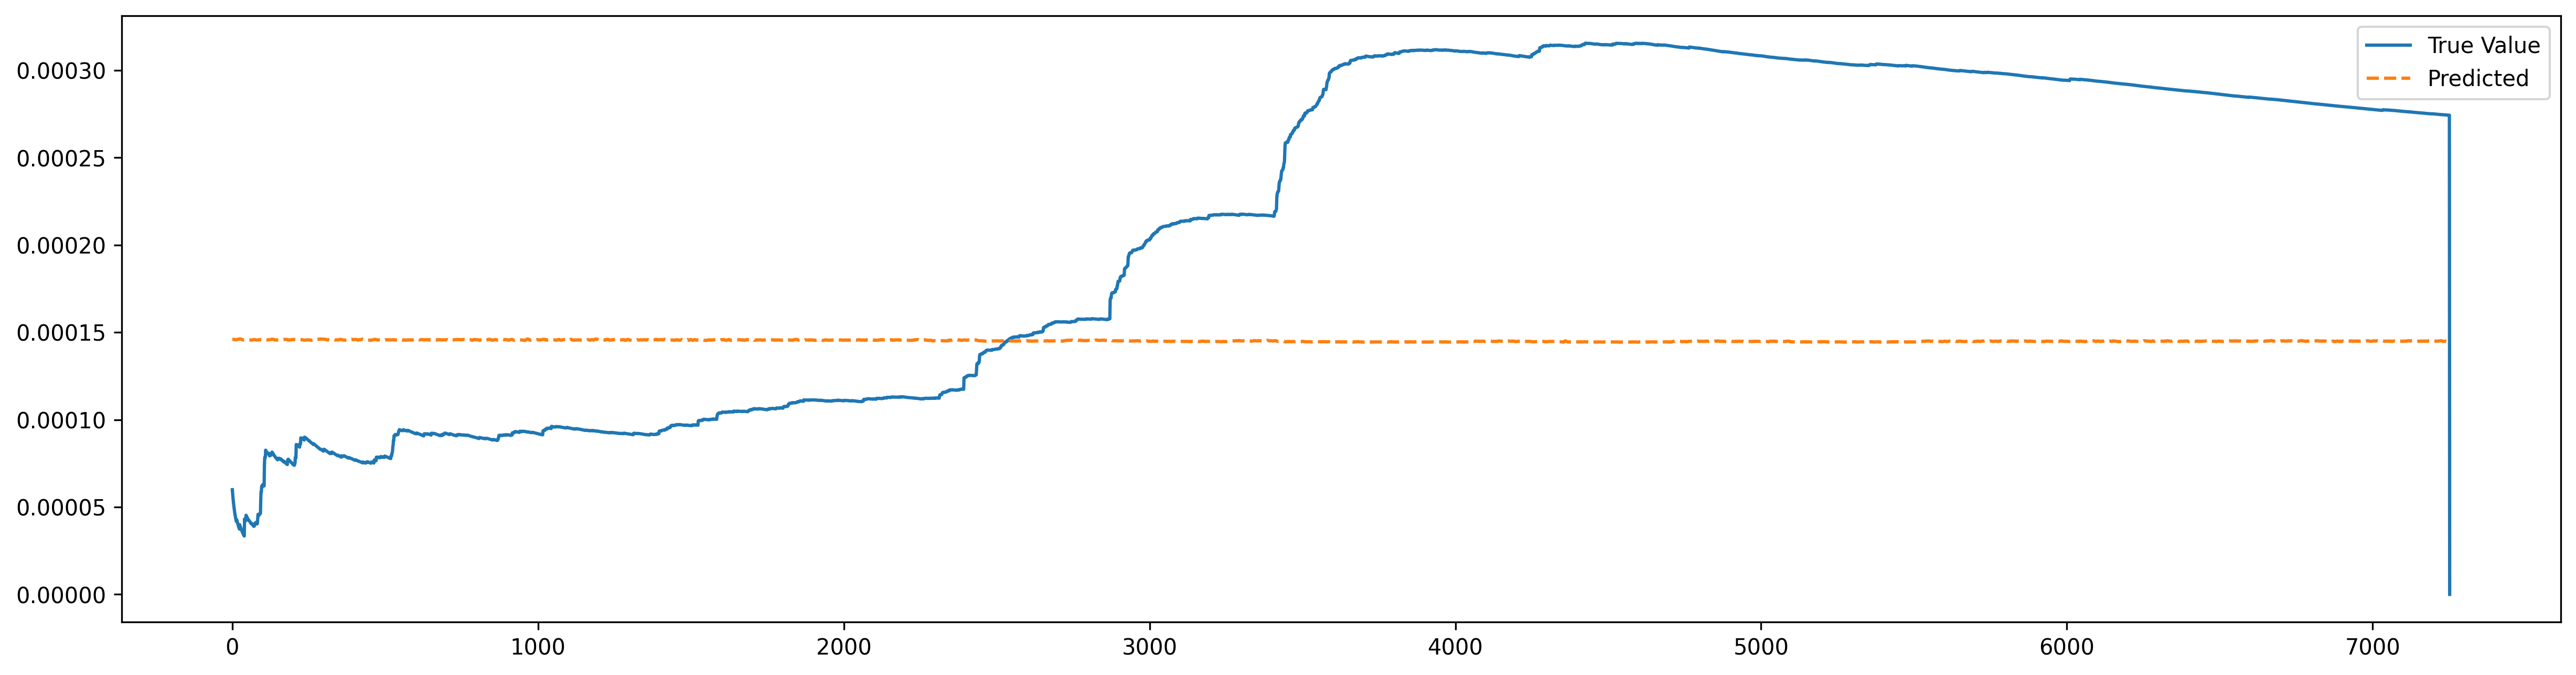

In [20]:
from sklearn.metrics import mean_absolute_error
pred = model.predict(X_new)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_new,label='True Value')
plt.plot(pred,linestyle='--', label = 'Predicted')
plt.legend()
plt.show()

In [24]:
pd.DataFrame(pred).value_counts

<bound method DataFrame.value_counts of              0
0     0.000146
1     0.000146
2     0.000146
3     0.000146
4     0.000146
...        ...
7248  0.000145
7249  0.000145
7250  0.000145
7251  0.000145
7252  0.000145

[7253 rows x 1 columns]>